In [1]:
import tensorflow as tf

from IPython.display import clear_output
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import albumentations as alb
from sklearn import metrics
import numpy as np
import skimage
import shutil
import time
import math
import glob
import json
import cv2
import os

# Set GPU Growth

In [2]:
# Avoid out of memory errors
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Build Data Pipeline

In [4]:
files = os.listdir("images/my_face/")

filenames = [files[i][:-4] for i in range(0, len(files), 2)]

In [5]:
def load_image(file):
    byte_img = tf.io.read_file(file)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [6]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.3),
                         alb.RandomGamma(p=0.3),
                         alb.RGBShift(p=0.3),
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [7]:
# # Detection dataset
# faces = 0
# total = 0

# for file in filenames:
#     if os.path.exists(f"images/my_face/{file}.json"):
#         img = cv2.imread(os.path.join('images', 'my_face', file + ".jpg"))
        
#         with open("images/my_face/" + file + ".json", "r") as f:
#             data = json.load(f)
#             coordinates = [0,0,0.00001,0.00001]
#             class_id = 0
#             if len(data["shapes"]) > 0:
#                 point = data["shapes"][0]["points"]
#                 coordinates[0] = point[0][0] / img.shape[1]
#                 coordinates[1] = point[0][1] / img.shape[0]
#                 coordinates[2] = point[1][0] / img.shape[1]
#                 coordinates[3] = point[1][1] / img.shape[0]
#                 class_id = 1
#                 faces += 1
#             total += 1

#         for i in range(10):
#             augmented = augmentor(image=np.array(img), bboxes=[coordinates], class_labels=["face"])
                
#             cv2.imwrite(os.path.join('images', 'augmented', 'detection_images', f'{file}.{i}.jpg'), augmented['image'])

#             annotation = {}
#             annotation['image'] = file

#             if not class_id:
#                 annotation['bbox'] = [0,0,0,0]
#                 annotation['class'] = 0 
#             else:
#                 cv2.imwrite(os.path.join('images', 'augmented', 'location_images', f'{file}.{i}.jpg'), augmented['image'])
#                 annotation['bbox'] = augmented['bboxes'][0]
#                 with open(os.path.join('images', 'augmented', 'location_labels', f'{file}.{i}.json'), 'w') as f:
#                     json.dump(annotation, f)
#                 annotation['class'] = 1

#             with open(os.path.join('images', 'augmented', 'detection_labels', f'{file}.{i}.json'), 'w') as f:
#                 json.dump(annotation, f)

In [8]:
# Detection dataset
filenames = os.listdir("images/detection/")
filenames = filenames + os.listdir("images/my_face")
filenames = [filenames[i][:-4] for i in range(0, len(filenames), 2)]

faces = 0
total = 0

folder = "none"

for file in filenames:
    if os.path.exists(f"images/detection/{file}.json"):
        folder = "detection"
    elif os.path.exists(f"images/my_face/{file}.json"):
        folder = "my_face"
        
    if folder != "none":
        img = cv2.imread(os.path.join('images', folder, file + ".jpg"))
        
        with open(f"images/{folder}/" + file + ".json", "r") as f:
            data = json.load(f)
            class_id = 0
            if len(data["shapes"]) > 0:
                class_id = 1
                faces += 1
            total += 1

        for i in range(10):
            augmented = augmentor(image=np.array(img), bboxes=[[0,0,0.00001,0.00001]], class_labels=["face"])
                
            cv2.imwrite(os.path.join('images', 'augmented', 'detection_images', f'{file}.{i}.jpg'), augmented['image'])

            annotation = {}
            annotation['image'] = file

            annotation['class'] = class_id

            with open(os.path.join('images', 'augmented', 'detection_labels', f'{file}.{i}.json'), 'w') as f:
                json.dump(annotation, f)
    folder = "none"

In [9]:
print("True outputs: ", faces)
print("False outputs: ", total - faces)

True outputs:  136
False outputs:  91


In [128]:
# Location dataset
filenames = os.listdir("images/my_face")
filenames = [filenames[i][:-4] for i in range(0, len(files), 2)]

for file in filenames:
    if os.path.exists(f"images/my_face/{file}.json"):
        img = cv2.imread(os.path.join('images', 'my_face', file + ".jpg"))
        
        with open("images/my_face/" + file + ".json", "r") as f:
            data = json.load(f)
            coordinates = [0,0,0.00001,0.00001]
            if len(data["shapes"]) > 0:
                point = data["shapes"][0]["points"]
                coordinates[0] = point[0][0] / img.shape[1]
                coordinates[1] = point[0][1] / img.shape[0]
                coordinates[2] = point[1][0] / img.shape[1]
                coordinates[3] = point[1][1] / img.shape[0]
                faces += 1

                for i in range(10):
                    augmented = augmentor(image=np.array(img), bboxes=[coordinates], class_labels=["face"])

                    cv2.imwrite(os.path.join('images', 'augmented', 'detection_images', f'{file}.{i}.jpg'), augmented['image'])

                    annotation = {}
                    annotation['image'] = file


                    cv2.imwrite(os.path.join('images', 'augmented', 'location_images', f'{file}.{i}.jpg'), augmented['image'])
                    annotation['bbox'] = augmented['bboxes'][0]
                    with open(os.path.join('images', 'augmented', 'location_labels', f'{file}.{i}.json'), 'w') as f:
                        json.dump(annotation, f)

In [10]:
detection_images = tf.data.Dataset.list_files('images\\augmented\\detection_images\\*.jpg', shuffle=False)
detection_images = detection_images.map(load_image)
detection_images = detection_images.map(lambda x: tf.image.resize(x, (120,120)))
detection_images = detection_images.map(lambda x: x/255)

In [147]:
location_images = tf.data.Dataset.list_files("images\\augmented\\location_images\\*.jpg", shuffle=False)
location_images = location_images.map(load_image)
location_images = location_images.map(lambda x: tf.image.resize(x, (120, 120)))
location_images = location_images.map(lambda x: x/255)

In [11]:
def load_detection_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']]

In [149]:
def load_location_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['bbox']]

In [12]:
detection_labels = tf.data.Dataset.list_files('images\\augmented\\detection_labels\\*.json', shuffle=False)
detection_labels = detection_labels.map(lambda x: tf.py_function(load_detection_labels, [x], [tf.uint8]))

In [194]:
location_labels = tf.data.Dataset.list_files("images\\augmented\\location_labels\\*.json", shuffle=False)
location_labels = location_labels.map(lambda x: tf.py_function(load_location_labels, [x], [tf.float16]))

In [13]:
detection_data = tf.data.Dataset.zip((detection_images, detection_labels))
detection_data = detection_data.shuffle(5000)
detection_data = detection_data.batch(8)
detection_data = detection_data.prefetch(4)

In [196]:
location_data = tf.data.Dataset.zip((location_images, location_labels))
location_data = location_data.shuffle(5000)
location_data = location_data.batch(8)
location_data = location_data.prefetch(4)

In [14]:
TRAIN_SIZE = int(len(detection_data) * .8)
VAL_SIZE = int((len(detection_data) - TRAIN_SIZE) / 2)

detection_train = detection_data.take(TRAIN_SIZE)
detection_val = detection_data.skip(TRAIN_SIZE).take(VAL_SIZE)
detection_test = detection_data.skip(TRAIN_SIZE + VAL_SIZE)

In [198]:
TRAIN_SIZE = int(len(location_data) * .8)
VAL_SIZE = int((len(location_data) - TRAIN_SIZE) / 2)

location_train = location_data.take(TRAIN_SIZE)
location_val = location_data.skip(TRAIN_SIZE).take(VAL_SIZE)
location_test = location_data.skip(TRAIN_SIZE + VAL_SIZE)

tf.Tensor([0.1823 0.3862 0.4697 0.796 ], shape=(4,), dtype=float16)
[21.88 46.34 56.38 95.5 ]


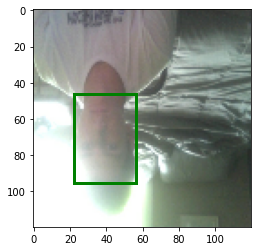

In [199]:
index = np.random.randint(8)
index = 6
rand_batch = np.random.randint(33)
for image, labels in location_train.skip(rand_batch).take(1):
    plt.imshow(image[index])
    
    point = np.array(labels[0][index]) * 120

    print(labels[0][index])
    print(point)
    plt.gca().add_patch(Rectangle((point[0],point[1]), point[2]-point[0], point[3]-point[1], 
                                  edgecolor="green", facecolor="none", lw=3))

tf.Tensor(1, shape=(), dtype=uint8)


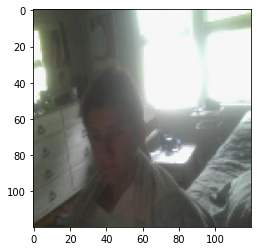

In [21]:
index = np.random.randint(8)
index = 6
rand_batch = np.random.randint(162)
for image, labels in detection_train.skip(rand_batch).take(1):
    plt.imshow(image[index])
    
    class_id = labels[0][index]

    print(class_id)

# Create Model

In [22]:
def detection_model():
    input = tf.keras.Input(shape=(120, 120, 3))
    
    base_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=(120, 120, 3))
#     base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=(120, 120, 3))
    out = base_model(input)
    
    x = tf.keras.layers.GlobalMaxPooling2D()(out)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=input, outputs=x)
    return model

In [23]:
def location_model():
    input = tf.keras.Input(shape=(120, 120, 3))
    
    base_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=(120, 120, 3))
#     base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=(120, 120, 3))
    out = base_model(input)
    
    x = tf.keras.layers.GlobalMaxPooling2D()(out)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(4, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=input, outputs=x)
    return model

In [24]:
detection = detection_model()
location = location_model()

In [25]:
detection.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,155,969
Trainable params: 20,155,969
Non-trainable params: 0
_________________________________________________

In [26]:
location.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 20,289,092
Trainable params: 20,289,092
Non-trainable params: 0
_______________________________________________

In [27]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [28]:
detection.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.BinaryCrossentropy())
location.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 loss=localization_loss)

In [29]:
detection_history = detection.fit(detection_train, epochs=50, validation_data=detection_val)

Epoch 1/50
227/227 [==============================] - 20s 31ms/step - loss: 0.5609 - val_loss: 0.3977
Epoch 2/50
227/227 [==============================] - 7s 30ms/step - loss: 0.3848 - val_loss: 0.3425
Epoch 3/50
227/227 [==============================] - 7s 30ms/step - loss: 0.2989 - val_loss: 0.2077
Epoch 4/50
227/227 [==============================] - 8s 30ms/step - loss: 0.1193 - val_loss: 0.0612
Epoch 5/50
227/227 [==============================] - 7s 29ms/step - loss: 0.0894 - val_loss: 0.0110
Epoch 6/50
227/227 [==============================] - 7s 30ms/step - loss: 0.0691 - val_loss: 0.0189
Epoch 7/50
227/227 [==============================] - 7s 30ms/step - loss: 0.0412 - val_loss: 0.0138
Epoch 8/50
227/227 [==============================] - 7s 30ms/step - loss: 0.0251 - val_loss: 4.7799e-04
Epoch 9/50
227/227 [==============================] - 7s 30ms/step - loss: 0.0257 - val_loss: 0.0088
Epoch 10/50
227/227 [==============================] - 7s 30ms/step - loss: 0.0024 - v

Calculating...
Done


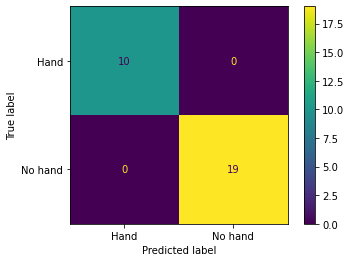

In [37]:
actual = []
predicted = []
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0

print("Calculating...")
for image, label in detection_test:
    for batch in range(len(label)):
        class_id = detection.predict(np.expand_dims(image[batch], axis=0), verbose=0)

        actual.append(label[0][batch])
        predicted.append(np.round(class_id[0][0]))

        if np.round(class_id[0][0]) == label[0][batch]:
            if class_id == 1:
                true_positive += 1
            else:
                true_negative += 1
        else:
            if class_id == 1:
                false_positive += 1
            else:
                false_negative += 1
print("Done")

confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Hand", "No hand"])

cm_display.plot()
plt.show()

In [222]:
location_history = location.fit(true_train, epochs=400, validation_data=true_val)

Epoch 1/400
34/34 [==============================] - 3s 66ms/step - loss: 0.0953 - val_loss: 0.0670
Epoch 2/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0760 - val_loss: 0.0856
Epoch 3/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0438 - val_loss: 0.0370
Epoch 4/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0338 - val_loss: 0.0335
Epoch 5/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0345 - val_loss: 0.0328
Epoch 6/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0380 - val_loss: 0.0271
Epoch 7/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0246 - val_loss: 0.0214
Epoch 8/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0234 - val_loss: 0.0217
Epoch 9/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0178 - val_loss: 0.0131
Epoch 10/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0099 - val_loss: 0.0108

34/34 [==============================] - 2s 67ms/step - loss: 0.0086 - val_loss: 0.0096
Epoch 162/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0067 - val_loss: 0.0043
Epoch 163/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0040 - val_loss: 0.0055
Epoch 164/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 165/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 166/400
34/34 [==============================] - 2s 66ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 167/400
34/34 [==============================] - 2s 66ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 168/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0015 - val_loss: 8.6926e-04
Epoch 169/400
34/34 [==============================] - 2s 66ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 170/400
34/34 [==============================] - 2s 67ms/step - loss: 0.0012 - val_los

34/34 [==============================] - 2s 65ms/step - loss: 7.3043e-04 - val_loss: 0.0017
Epoch 318/400
34/34 [==============================] - 2s 65ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 319/400
34/34 [==============================] - 2s 65ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 320/400
34/34 [==============================] - 2s 66ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 321/400
34/34 [==============================] - 2s 66ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 322/400
34/34 [==============================] - 2s 66ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 323/400
34/34 [==============================] - 2s 66ms/step - loss: 0.0016 - val_loss: 6.7034e-04
Epoch 324/400
34/34 [==============================] - 2s 66ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 325/400
34/34 [==============================] - 2s 66ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 326/400
34/34 [==============================] - 2s 65ms/step - loss: 0.0016 - val

Epoch 395/400
34/34 [==============================] - 2s 65ms/step - loss: 5.1383e-04 - val_loss: 4.0257e-04
Epoch 396/400
34/34 [==============================] - 2s 65ms/step - loss: 4.7844e-04 - val_loss: 6.5364e-04
Epoch 397/400
34/34 [==============================] - 2s 65ms/step - loss: 6.2066e-04 - val_loss: 0.0018
Epoch 398/400
34/34 [==============================] - 2s 65ms/step - loss: 9.2141e-04 - val_loss: 5.7073e-04
Epoch 399/400
34/34 [==============================] - 2s 65ms/step - loss: 6.4236e-04 - val_loss: 5.0271e-04
Epoch 400/400
34/34 [==============================] - 2s 65ms/step - loss: 8.6524e-04 - val_loss: 4.9990e-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


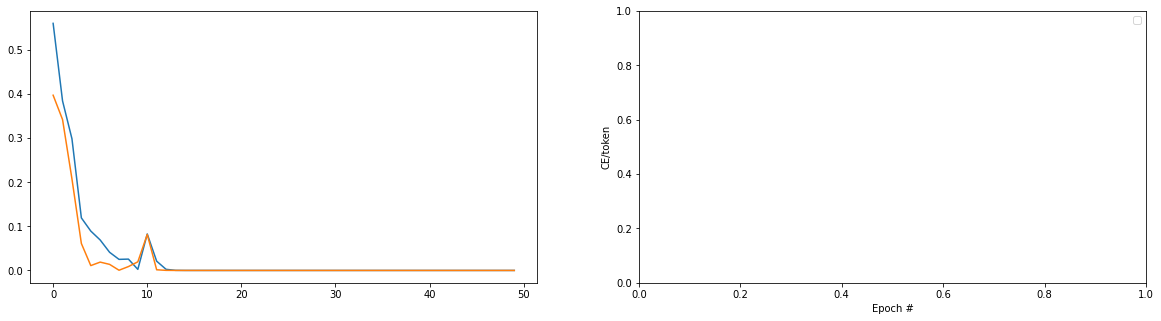

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))

ax[0].plot(detection_history.history['loss'], label='loss')
ax[0].plot(detection_history.history['val_loss'], label='val_loss')
ax[1].plot(location_history.history['loss'], label='loss')
ax[1].plot(location_history.history['val_loss'], label='val_loss')

plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

1/1 [==============================] - 0s 90ms/step
1.0
[49.96819 65.04741 90.84972 99.98219]


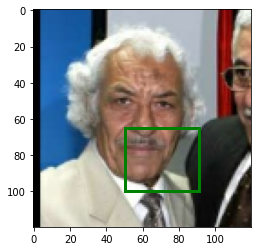

In [39]:
for image, label in detection_test.skip(1).take(1):
    image = image[0]
    plt.imshow(np.array(image))
    
    class_id = detection.predict(np.array([image]))
    point = location.predict(np.array([image]))
    point = point[0] * 120.0
    
    print(class_id[0][0])
    print(point)
    
    if class_id[0][0] > .1:
        plt.gca().add_patch(Rectangle((point[0], point[1]), point[2]-point[0], point[3]-point[1],
                                     edgecolor="green", facecolor="none", lw=3))

1/1 [==============================] - 0s 0s/step
0.18421196937561035
1.0
[180.94034195 145.27257442 486.8624115  406.60640717]


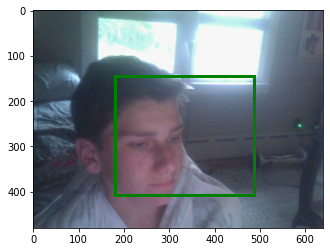

In [232]:
image = load_image("images/Nathan1.jpeg")
shape = image.shape
plt.imshow(np.array(image)/255.0)

image = np.array([tf.image.resize(image, (120, 120))])/255.0

start = time.time()
class_id = detection.predict(image)
point = location.predict(image)
print(time.time() - start)
point = point[0] * [shape[1], shape[0], shape[1], shape[0]]

print(class_id[0][0])
print(point)

if class_id[0][0] > 0:
    plt.gca().add_patch(Rectangle((point[0],point[1]), point[2]-point[0], point[3]-point[1], 
                                  edgecolor="green", facecolor="none", lw=3))

# Implement

In [42]:
detection.save("face_detection")
location.save("face_location")

INFO:tensorflow:Assets written to: face_detection\assets


INFO:tensorflow:Assets written to: face_detection\assets


In [52]:
detection = tf.keras.models.load_model("face_detection")
location = tf.keras.models.load_model("face_location", compile=False)

In [41]:
cap = cv2.VideoCapture(0)

while True:
    _, frame = cap.read()

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(rgb, (120, 120))
    class_id = detection.predict(np.array([img])/255.0, verbose=0)
    point = location.predict(np.array([img])/255.0, verbose=0)
    point = point[0] * [640, 480, 640, 480]

    if class_id[0][0] > 0.5:
        frame = cv2.putText(frame, f"Score: {class_id[0][0]}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        frame = cv2.rectangle(frame, (int(point[0]), int(point[1])), 
                            (int(point[2]), int(point[3])), color=(0, 255, 0))
    
    print(frame.shape)
    cv2.imshow("Window", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 

# Convert to TFLite

In [44]:
def representative_dataset():
    for _ in range(100):
        data = np.random.rand(1, 120, 120, 3)
        yield [data.astype(np.float16)]

In [45]:
converter = tf.lite.TFLiteConverter.from_saved_model("face_detection")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

with open("face_detection.tflite", "wb") as f:
    f.write(tflite_model)

In [46]:
converter = tf.lite.TFLiteConverter.from_saved_model("face_location")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

with open("face_location.tflite", "wb") as f:
    f.write(tflite_model)

In [47]:
detection_interpreter = tf.lite.Interpreter("face_detection.tflite")
detection_signature = detection_interpreter.get_signature_runner()

location_interpreter = tf.lite.Interpreter("face_location.tflite")
location_signature = location_interpreter.get_signature_runner()

Time taken:  0.21059012413024902
0.99208283
[130.45106888 157.24403858 427.22496033 451.30785942]


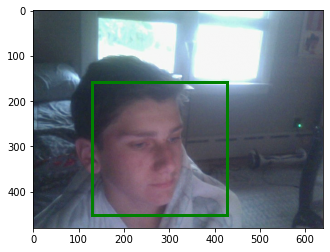

In [50]:
image = load_image("images/Nathan1.jpeg")
shape = image.shape
plt.imshow(np.array(image) / 255.0)

image = tf.image.resize(image, (120, 120)) / 255.0
image = np.array([image])

start = time.time()
class_id = detection_signature(input_43=tf.cast(image, tf.float32))
class_id = class_id["dense_41"]
coordinates = location_signature(input_45=tf.cast(image, tf.float32))
coordinates = coordinates["dense_43"]
print("Time taken: ", time.time() - start)

point = coordinates[0] * [shape[1], shape[0], shape[1], shape[0]]

print(class_id[0][0])
print(point)

if class_id[0][0] > 0:
    plt.gca().add_patch(Rectangle((point[0],point[1]), point[2]-point[0], point[3]-point[1], 
                                  edgecolor="green", facecolor="none", lw=3))